# Analysis of Power Spectrum Density (PSD)

Goal:
- Extract frequencies present in uncertainty heatmap
- Return minimal and maximal occuring frequencies

Interpretation:
- Slow changes of uncertainty across the heatmap (e.g. large regions of constant uncertainty values) are reflected by low frequencies (= large wavelength).
- High changes of uncertainty across the heatmap (e.g. global background noise) are reflected by high frequencies (= short wavelength).

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.signal import convolve
import scipy.signal

%load_ext autoreload
%autoreload 2

from aggrigator.datasets import generate_random_binary_array_with_squares, generate_random_array_with_correlated_noise, generate_two_dim_sin_cos_wave
from aggrigator.aggregation_functions import agg_function
from aggrigator.psd import rapsd, plot_rapsd, plot_psd, plot_raautocorr, radial_average_autocorr



def generate_test_array(x_max, y_max, sin_freq=(1,0), cos_freq=(0,1), sin_ampl=1, cos_ampl=1):
    '''
    Generate a 2D array with a sin and cos wave in x and y direction

    params:
    x_max, y_max : int, x and y dimensions of the array
    freq_x, freq_y : float, frequency of the sin wave in x direction (the cos wave in y direction)
    phase_x, phase_y : float, phase of the sin wave in x direction (the cos wave in y direction)
    '''

    array = np.zeros((x_max, y_max))
    x = np.arange(x_max)
    y = np.arange(y_max)

    xx, yy = np.meshgrid(x, y)

    array = sin_ampl * np.sin(2 * np.pi * (sin_freq[0] * xx + sin_freq[1]*yy)) + cos_ampl * np.cos(2 * np.pi * (cos_freq[0] * xx + cos_freq[1] * yy))

    return array

## Generate sine array

- Generate a 2D heatmap using a superposition of a sine and cosine wave with fixed frequencies.
- The frequencies per wave are given by a 2D vector representing the wave direction.
- Goal of the PSD analysis is to recover these frequencies.

NOTE:
- The axes of the PSD plot are normalized.
- Due to the discrete nature of the heatmaps, the maximal frequency that can be captured is 0.5 (i.e. a periodic wave alternating every second pixel).
- Frequencies higher than 0.5 are indistinguishable from lower frequencies because of undersampling (they are also called aliased frequencies, which "fold back" to the range within 0.5).
- Extremal case example: A frequency of 1 (i.e. a wave periodic in one pixel) is indistinguishable from a frequency of 0 (i.e. a constant wave).

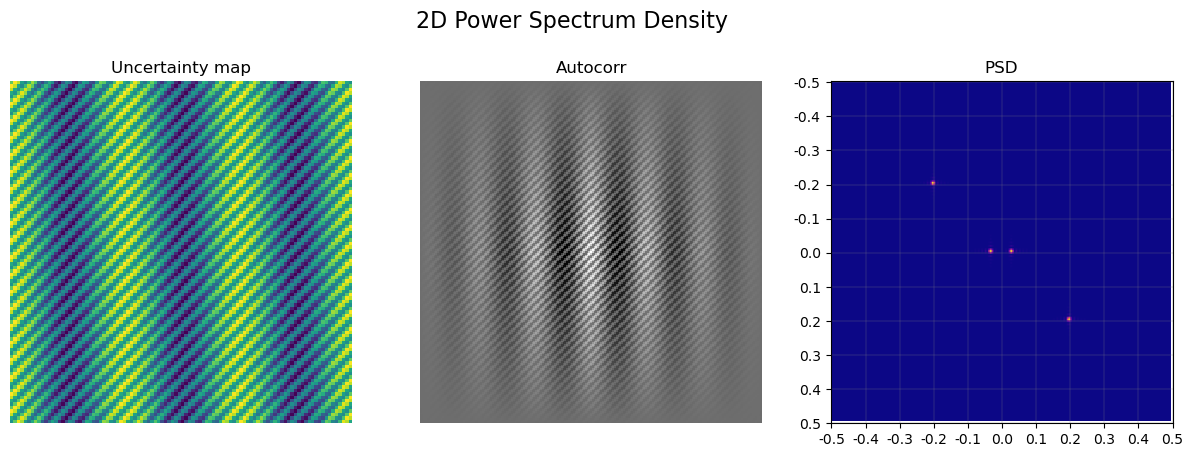

In [3]:
sin_x_freq = 0.2
sin_y_freq = 0.2
sin_ampl = 1

cos_x_freq = 0.03
cos_y_freq = 0.0
cos_ampl = 1


# NOTE: PSD axis ticks urrently only work for an array size of 100x100.
sin_cos_arr = generate_test_array(100, 100, sin_freq=(sin_x_freq, sin_y_freq), cos_freq=(cos_x_freq, cos_y_freq), sin_ampl=sin_ampl, cos_ampl=cos_ampl) 
plot_psd(sin_cos_arr)

- The Radially Averaged Power Spectrum Density (RAPSD) condensed the 2D information of the PSD array into a 1D distribution of frequencies.
- Peaks in the RAPSD curve correspond to frequencies present in the original uncertainty map.

Note: The radial average is not taken across pixels in the corners of the array. That is whay large frequencies appearing in the corners of the PSD plot are not present in the RAPSD plot.

Peak Frequencies: [0.03, 0.28]
Peak Wavelengths [in pixels]: [33, 3]


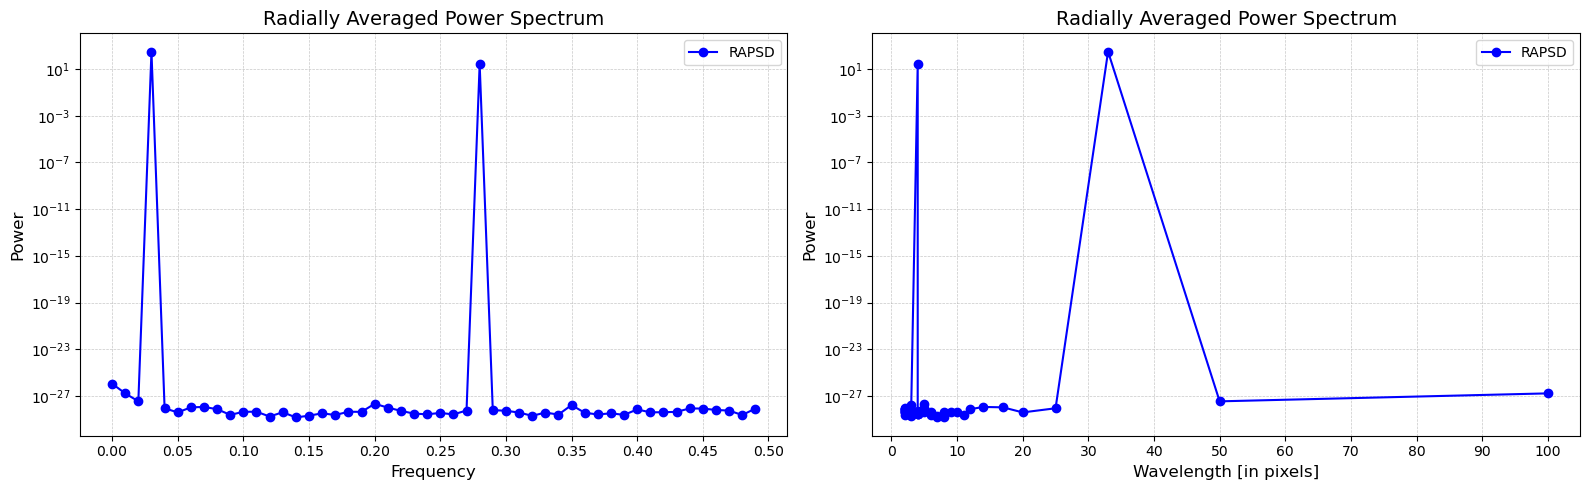

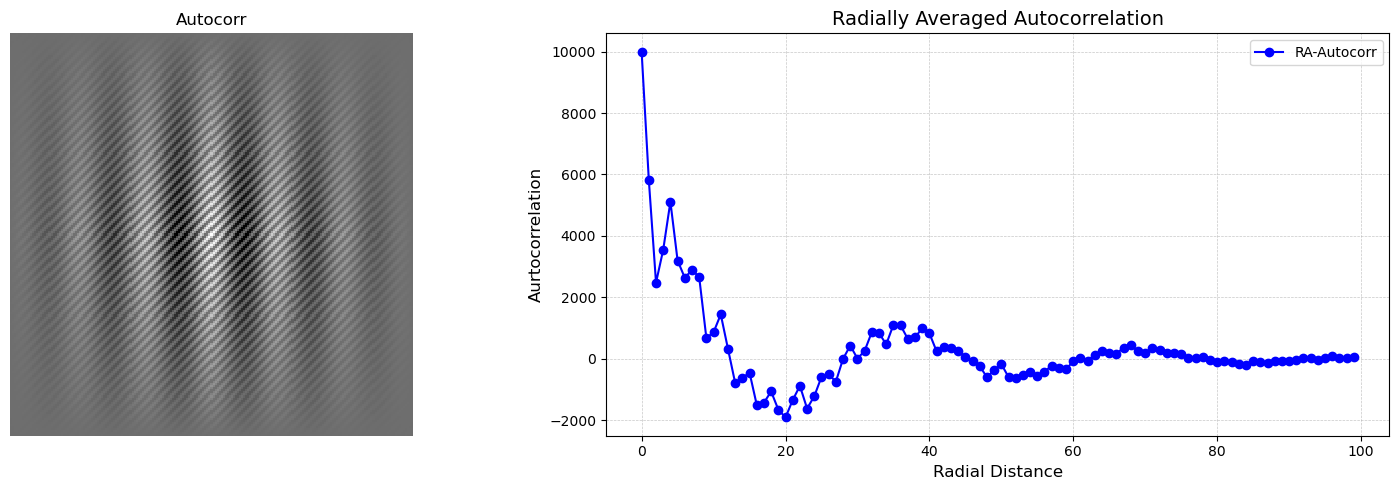

In [33]:
powers, frequencies = rapsd(sin_cos_arr)

plot_rapsd(sin_cos_arr)
plot_raautocorr(sin_cos_arr)

# Find peaks
peak_indices, properties = scipy.signal.find_peaks(powers, height=0.5)  # Adjust `height` as needed

# Extract peak frequencies and power
peak_frequencies = [float(frequencies[i]) for i in peak_indices]
peak_wavelengths = [int(1/f) for f in peak_frequencies]
print("Peak Frequencies:", peak_frequencies)
print("Peak Wavelengths [in pixels]:", peak_wavelengths)


## Evaluation on toy data

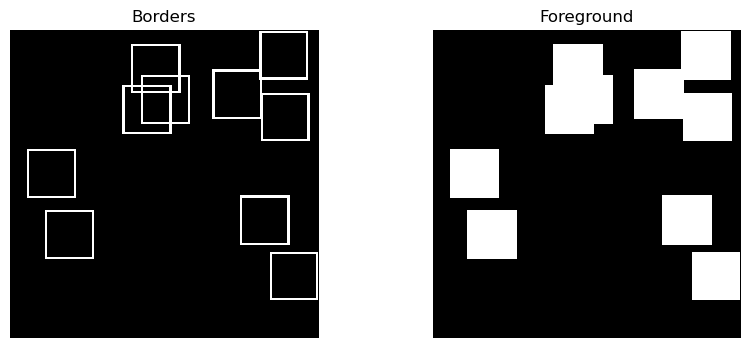

In [6]:
array_size = 500
num_squares = 10
square_size = 80

array, fg = generate_random_binary_array_with_squares(array_size, num_squares, square_size, square_size_var=0.01, width=4, intersect=True, FG=True)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(array, interpolation="none", cmap="gray")
plt.axis("off")
plt.title("Borders")

plt.subplot(1, 2, 2)
plt.imshow(fg, interpolation="none", cmap="gray")

plt.axis("off")
plt.title("Foreground")

plt.show()

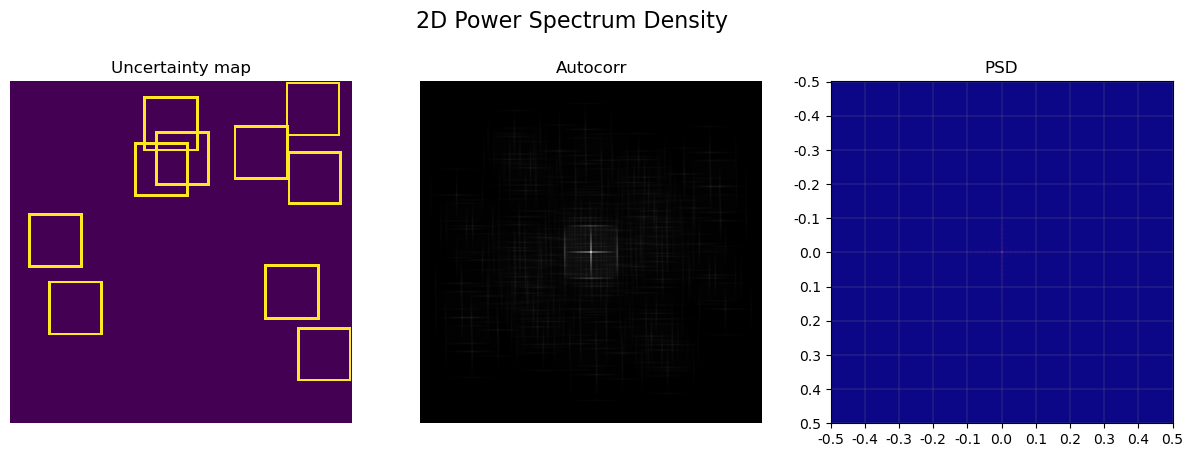

In [7]:
plot_psd(array)

Peak Frequencies: [0.014, 0.028, 0.04, 0.054, 0.066, 0.078, 0.092, 0.10400000000000001, 0.12]
Peak Wavelengths [in pixels]: [71, 35, 25, 18, 15, 12, 10, 9, 8]
Peak Autocorrelation Radii: [77, 131, 193, 225, 269]


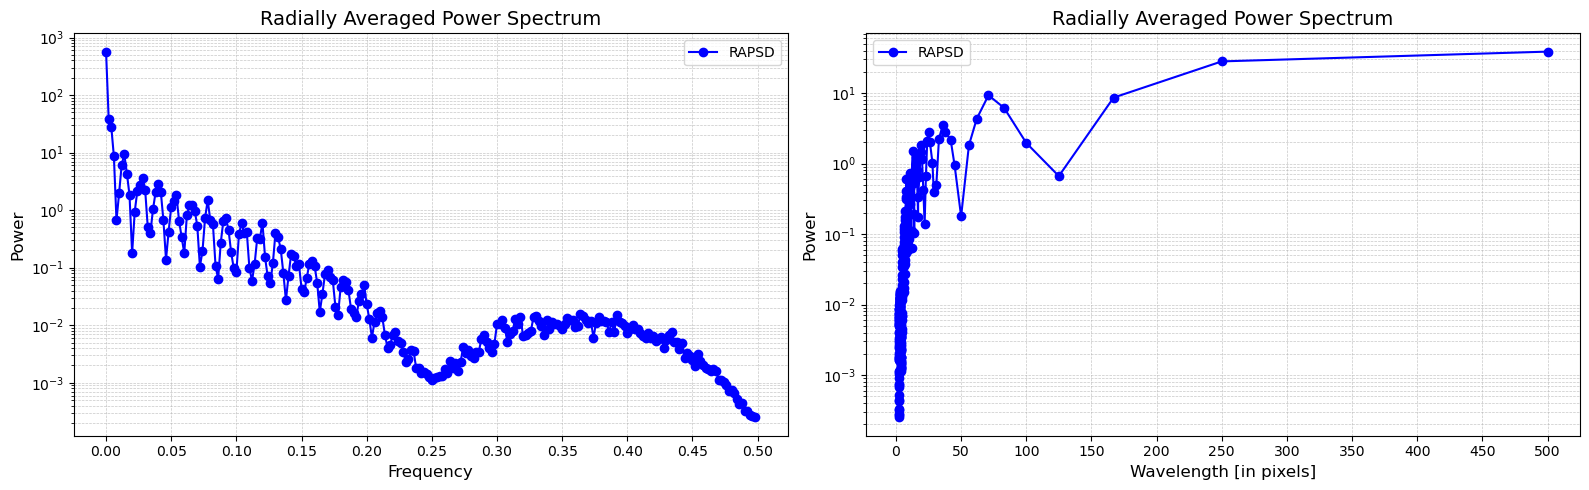

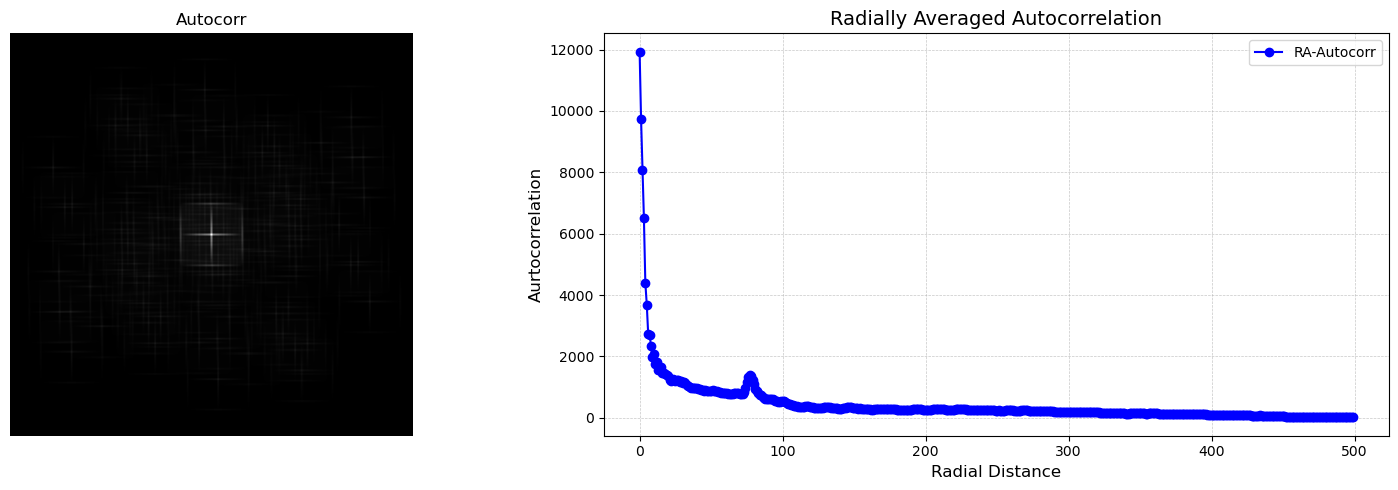

In [30]:
power, freq = rapsd(array)
plot_rapsd(array)
radii, radial_avg = radial_average_autocorr(array)
plot_raautocorr(array)

# Find peaks
peak_indices, properties = scipy.signal.find_peaks(power, height=0.5)  # Adjust `height` as needed
peak_radial_avg, _ = scipy.signal.find_peaks(radial_avg, width=5, distance=20) # NOTE: Requires Hyp-param tuning. Not nice :/

# Extract peak frequencies and power
peak_frequencies = [float(freq[i]) for i in peak_indices]
peak_wavelengths = [int(1/f) for f in peak_frequencies]
peak_radii = [int(radii[i]) for i in peak_radial_avg]
print("Peak Frequencies:", peak_frequencies)
print("Peak Wavelengths [in pixels]:", peak_wavelengths)
print("Peak Autocorrelation Radii:", peak_radii)

## Add noise

Peak Frequencies: [0.014, 0.028, 0.04, 0.054, 0.066, 0.078, 0.092, 0.10400000000000001, 0.12]
Peak Wavelengths [in pixels]: [71, 35, 25, 18, 15, 12, 10, 9, 8]
Peak Autocorrelation Radii: [77]


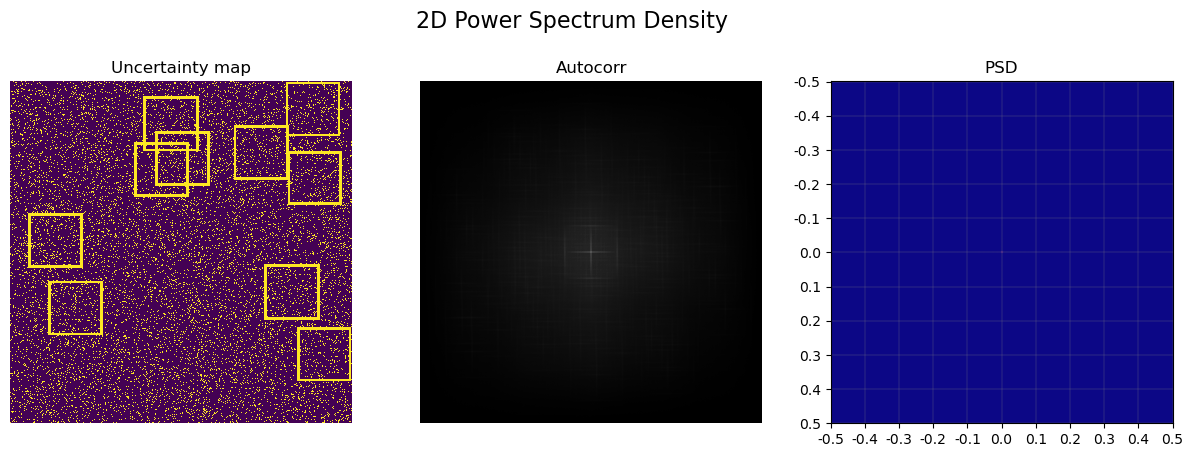

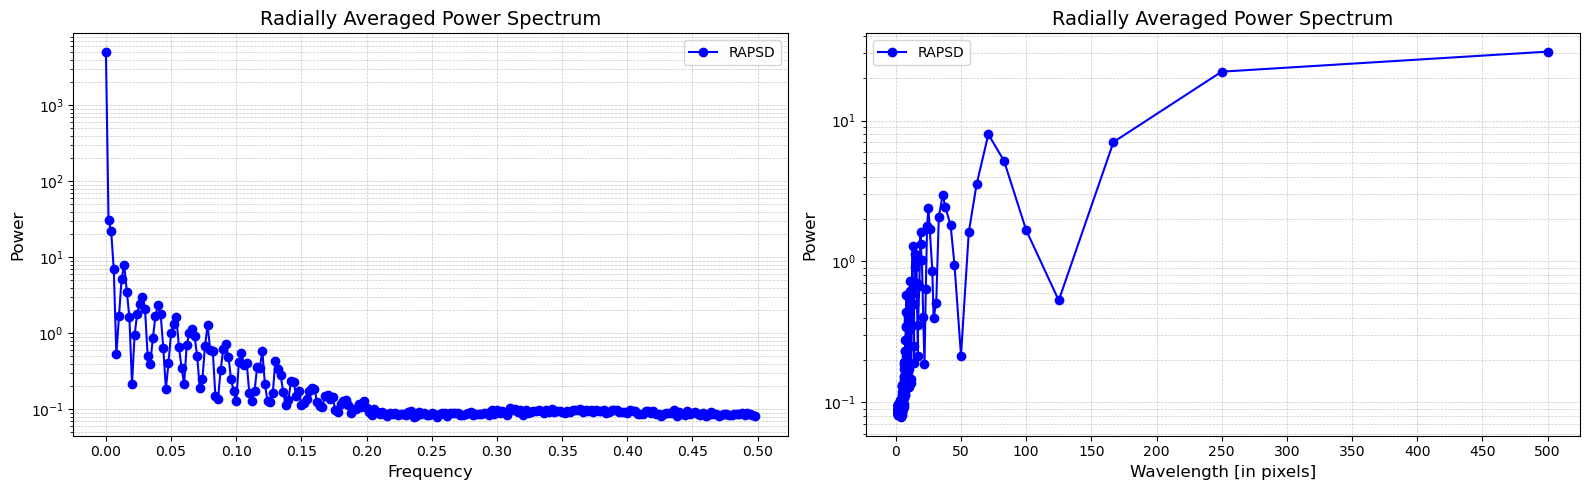

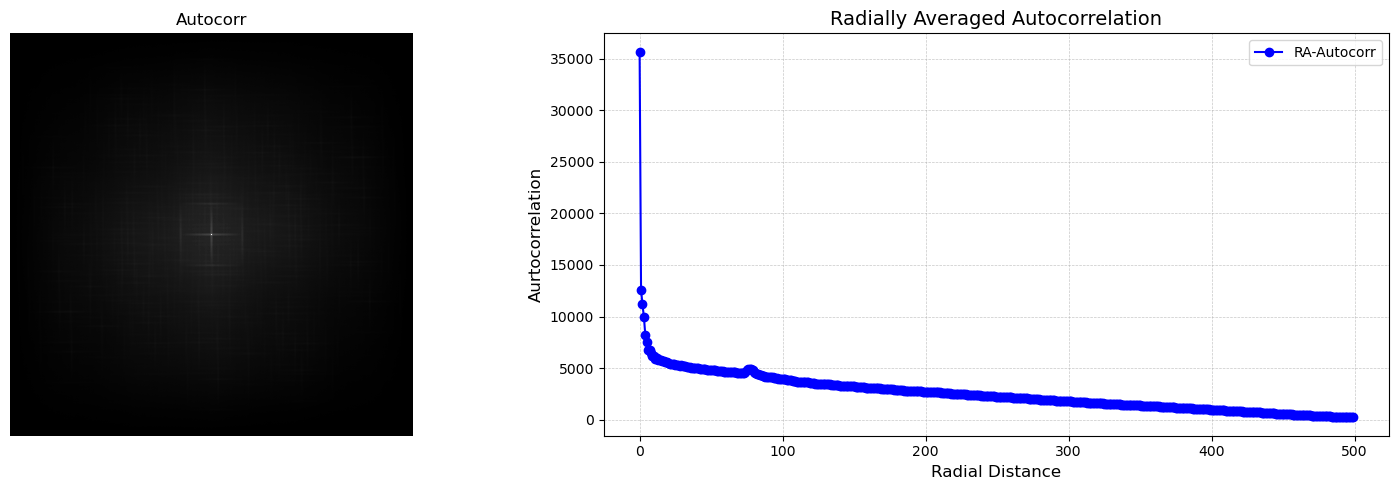

In [32]:
p = 0.9
data_rand = np.random.rand(500, 500)
data_rand = (data_rand > p).astype(int)

noisy_array = np.maximum(array.astype(int), data_rand)

plot_psd(noisy_array)

power, freq = rapsd(noisy_array)
plot_rapsd(noisy_array)
radii, radial_avg = radial_average_autocorr(noisy_array)
plot_raautocorr(noisy_array)

# Find peaks
peak_indices, properties = scipy.signal.find_peaks(power, height=0.5)  # Adjust `height` as needed
peak_radial_avg, _ = scipy.signal.find_peaks(radial_avg, width=5, distance=20) # NOTE: Requires Hyp-param tuning. Not nice :/

# Extract peak frequencies and power
peak_frequencies = [float(freq[i]) for i in peak_indices]
peak_wavelengths = [int(1/f) for f in peak_frequencies]
peak_radii = [int(radii[i]) for i in peak_radial_avg]
print("Peak Frequencies:", peak_frequencies)
print("Peak Wavelengths [in pixels]:", peak_wavelengths)
print("Peak Autocorrelation Radii:", peak_radii)

## Example: Random vs Checkerboard vs Block-Array

Peak Frequencies: []
Peak Wavelengths [in pixels]: []
Peak Autocorrelation Radii: []
Peak Frequencies: []
Peak Wavelengths [in pixels]: []
Peak Autocorrelation Radii: []
Peak Frequencies: [0.006, 0.01, 0.014, 0.018000000000000002, 0.022, 0.026000000000000002, 0.03, 0.034, 0.038, 0.042, 0.046, 0.05, 0.054, 0.058, 0.062]
Peak Wavelengths [in pixels]: [166, 100, 71, 55, 45, 38, 33, 29, 26, 23, 21, 20, 18, 17, 16]
Peak Autocorrelation Radii: []


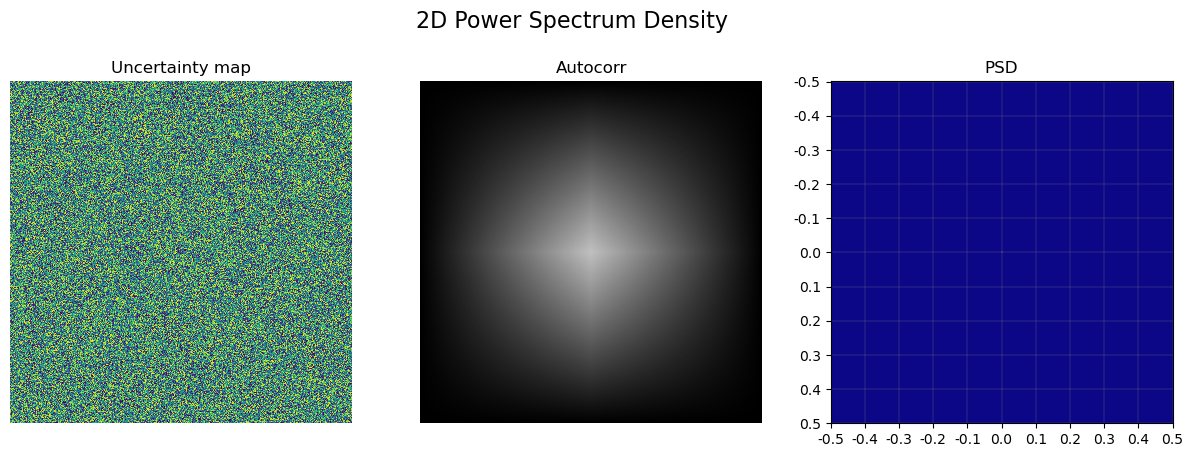

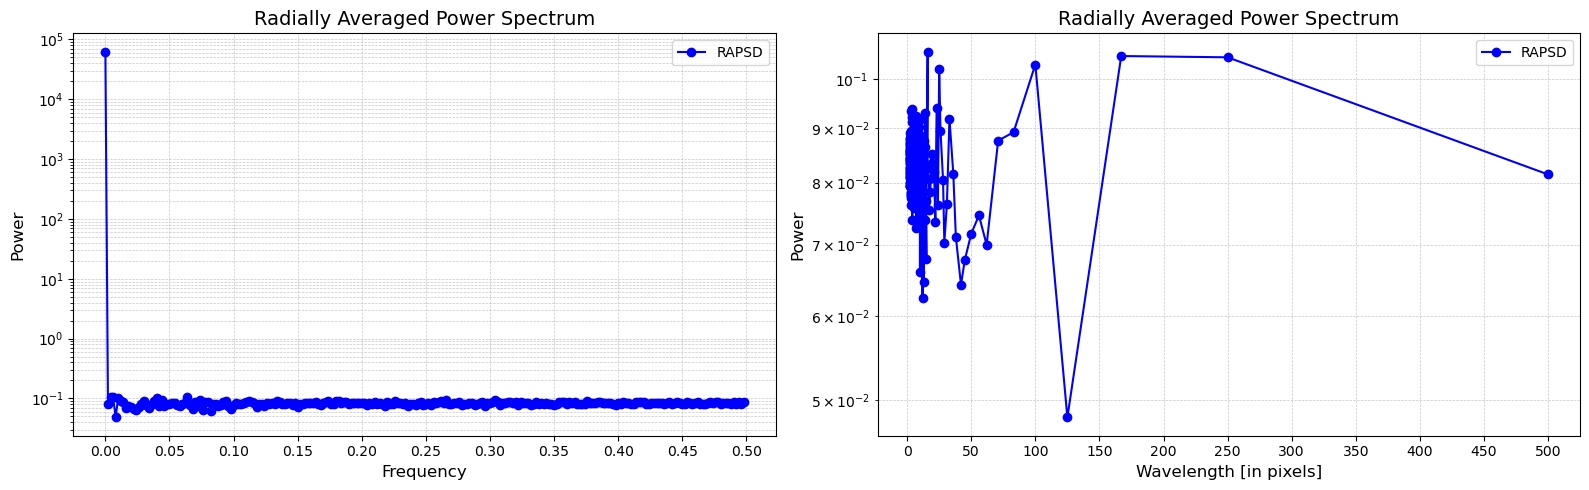

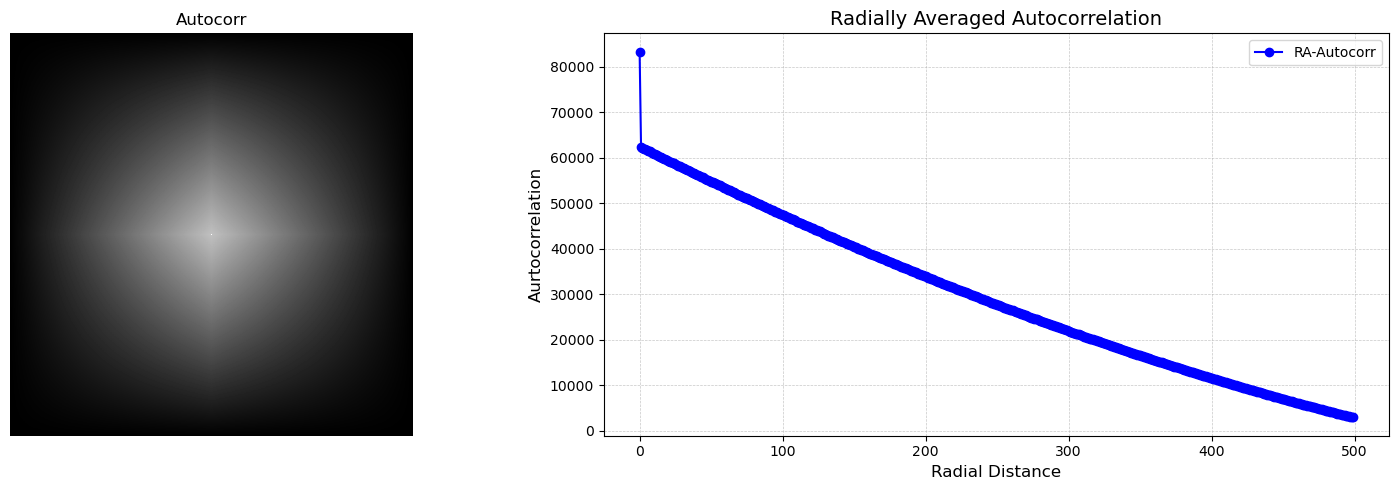

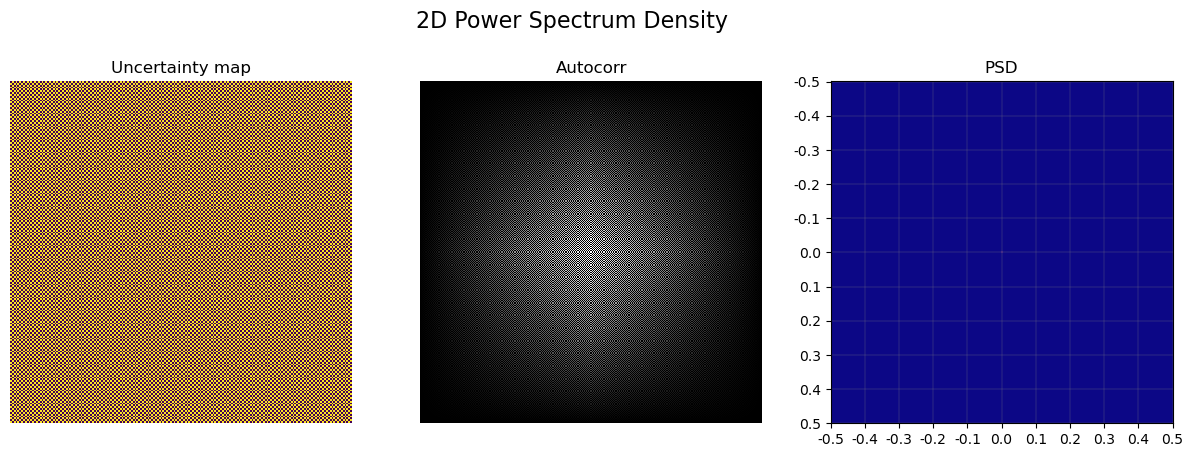

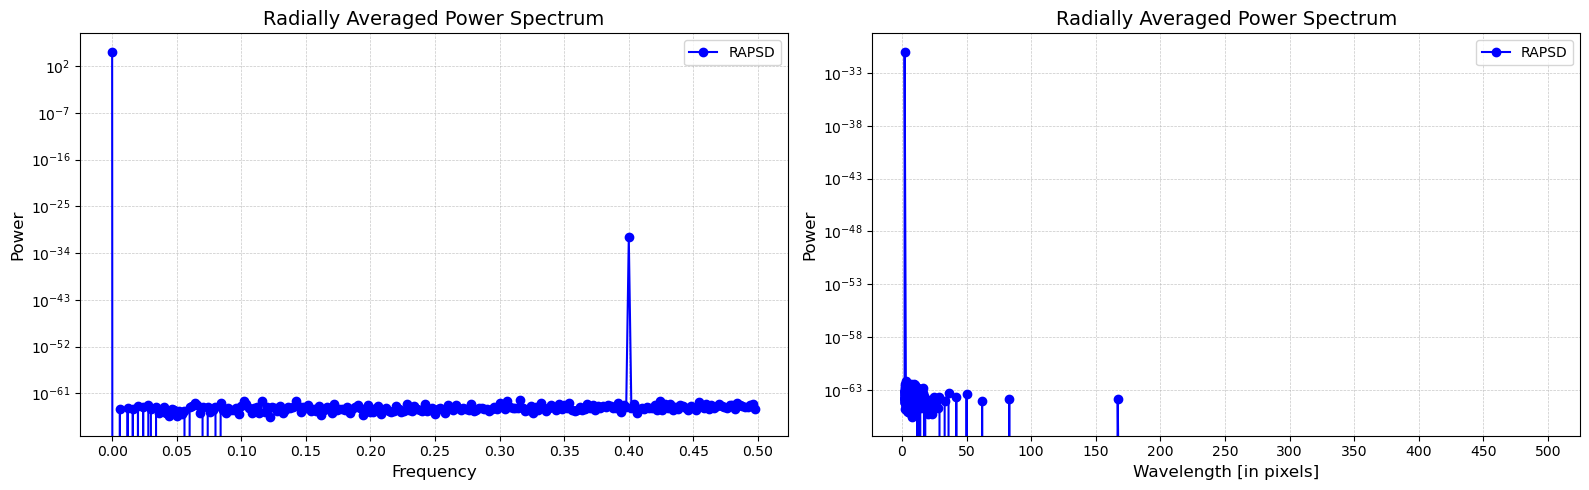

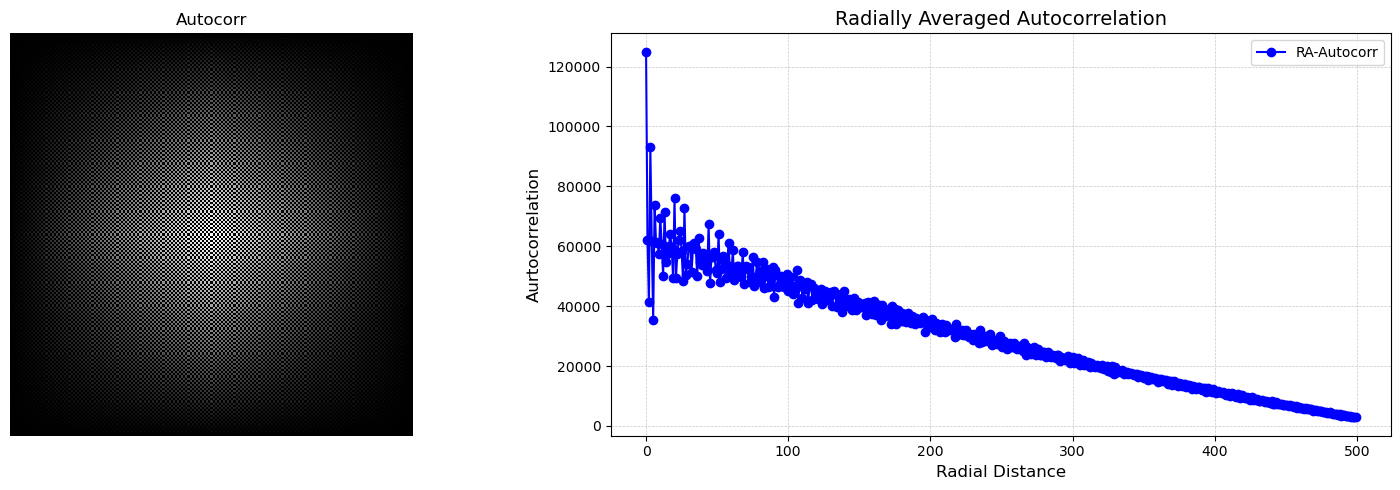

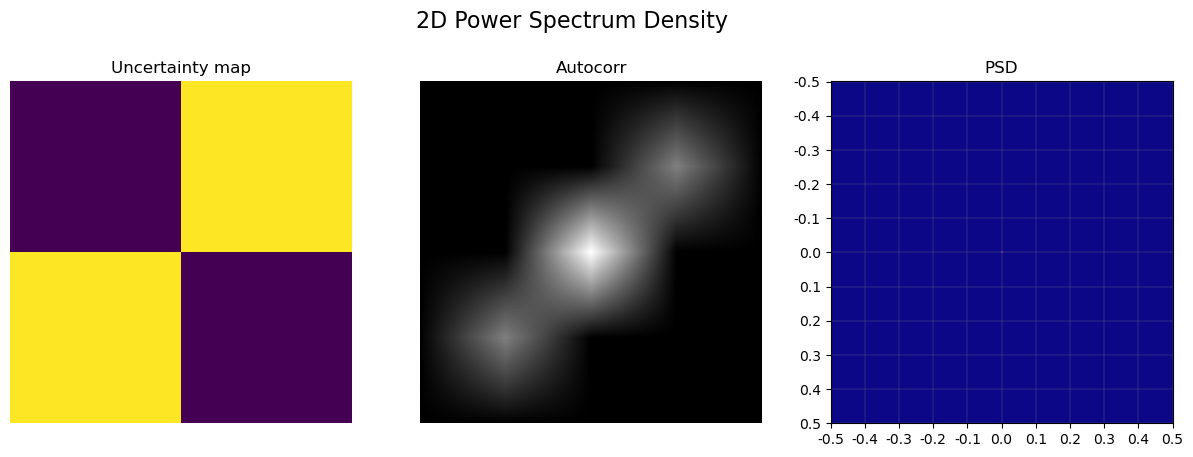

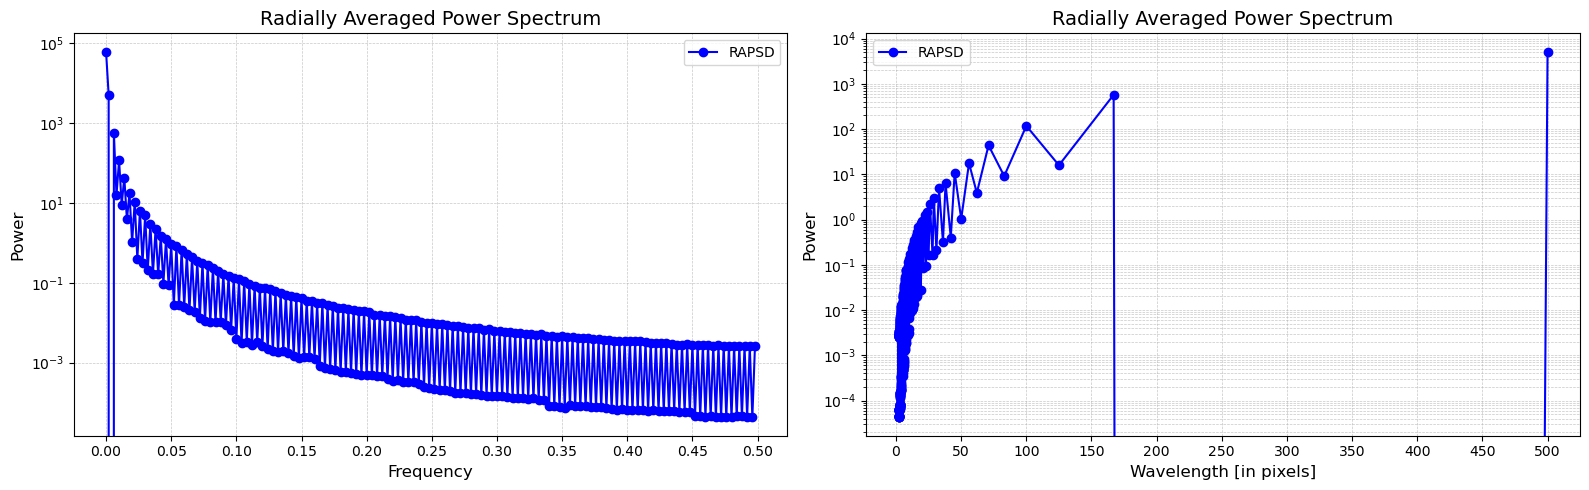

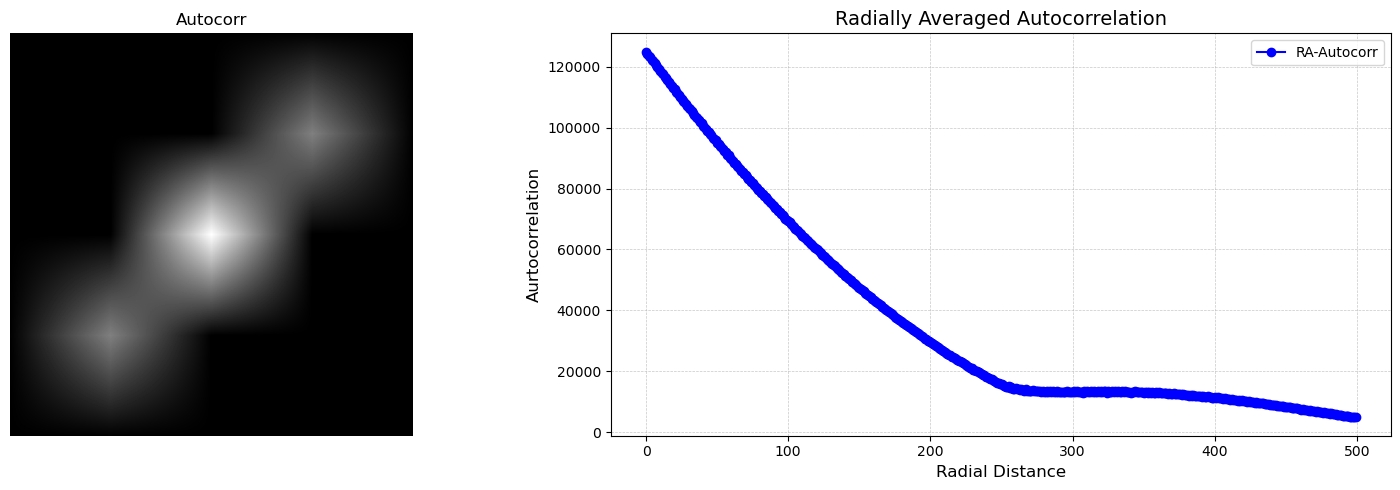

In [38]:
SIZE = 500

# NOISY
p = 0.5
data_rand = np.random.rand(SIZE, SIZE)
noisy_array = data_rand

plot_psd(noisy_array)

power, freq = rapsd(noisy_array)
plot_rapsd(noisy_array)
radii, radial_avg = radial_average_autocorr(noisy_array)
plot_raautocorr(noisy_array)

# Find peaks
peak_indices, properties = scipy.signal.find_peaks(power, height=0.5)  # Adjust `height` as needed
peak_radial_avg, _ = scipy.signal.find_peaks(radial_avg, width=5, distance=20) # NOTE: Requires Hyp-param tuning. Not nice :/

# Extract peak frequencies and power
peak_frequencies = [float(freq[i]) for i in peak_indices]
peak_wavelengths = [int(1/f) for f in peak_frequencies]
peak_radii = [int(radii[i]) for i in peak_radial_avg]
print("Peak Frequencies:", peak_frequencies)
print("Peak Wavelengths [in pixels]:", peak_wavelengths)
print("Peak Autocorrelation Radii:", peak_radii)


# CHECKERBOARD
from src.datasets import generate_checkerboard_array, generate_binary_quadrant_array
noisy_array = generate_checkerboard_array(SIZE)

plot_psd(noisy_array)

power, freq = rapsd(noisy_array)
plot_rapsd(noisy_array)
radii, radial_avg = radial_average_autocorr(noisy_array)
plot_raautocorr(noisy_array)

# Find peaks
peak_indices, properties = scipy.signal.find_peaks(power, height=0.5)  # Adjust `height` as needed
peak_radial_avg, _ = scipy.signal.find_peaks(radial_avg, width=5, distance=20) # NOTE: Requires Hyp-param tuning. Not nice :/

# Extract peak frequencies and power
peak_frequencies = [float(freq[i]) for i in peak_indices]
peak_wavelengths = [int(1/f) for f in peak_frequencies]
peak_radii = [int(radii[i]) for i in peak_radial_avg]
print("Peak Frequencies:", peak_frequencies)
print("Peak Wavelengths [in pixels]:", peak_wavelengths)
print("Peak Autocorrelation Radii:", peak_radii)


# BLOCK_ARRAY
noisy_array = generate_binary_quadrant_array(SIZE)

plot_psd(noisy_array)

power, freq = rapsd(noisy_array)
plot_rapsd(noisy_array)
radii, radial_avg = radial_average_autocorr(noisy_array)
plot_raautocorr(noisy_array)

# Find peaks
peak_indices, properties = scipy.signal.find_peaks(power, height=0.5)  # Adjust `height` as needed
peak_radial_avg, _ = scipy.signal.find_peaks(radial_avg, width=5, distance=20) # NOTE: Requires Hyp-param tuning. Not nice :/

# Extract peak frequencies and power
peak_frequencies = [float(freq[i]) for i in peak_indices]
peak_wavelengths = [int(1/f) for f in peak_frequencies]
peak_radii = [int(radii[i]) for i in peak_radial_avg]
print("Peak Frequencies:", peak_frequencies)
print("Peak Wavelengths [in pixels]:", peak_wavelengths)
print("Peak Autocorrelation Radii:", peak_radii)